# Created on Mon Feb  1 14:39:07 2016

@author: rubenbiesheuvel

This program creates a way to calculate argon as a liquid, and what happens afterwards

The steps we have to take are the following:

Initialize:
    
    import libraries
    
    Put particles in place
    
    Give particles speed and direction
    
For each timestep:
    
    Calculate the force on each particle, dependent on the Leonard Jones potential
    
    Calculate the path the are going ot take using the Velocity-verlet
    
    Store the new place and velocity (velocity for temperature calculations)


In [20]:
import numpy as np
import math as math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import product
%matplotlib inline

The following code initialzes the system, i.e. it puts the particles in a fcc grid of 3x3x3 unit cells. After that it creates random vectors for the speed of the particles. Taken from a gaussian distribution. To find the variance, the gaussian distribution was compared to a Maxwell distribution of speed for 1 velocity, being:

\begin{equation}
f(v_{x}) = \sqrt{\frac{m}{2 \pi k T}} e^{\frac{-m v_{x}^2}{2 k T}}
\end{equation}


In [205]:
#constants
T = 1 #temperature in Kelvin
L = 6 #number of unit cells in 3 directions
Z = 4 #number of atoms per unit cell
N = Z*L**3 #number of atoms in total space
l = 2**(1/6) #unit space length
ld = L*l #computational domain

epsilon = 1 #normalized units
M = 1 #39.948 * 1.660538921*10**(-27) #mass argon in kg
k = epsilon #boltzmann constatnt in SI units

# build a structure of atoms such that they are fcc spaced in and LxLxL unit space of length l
def init_pos(l):
    # particles in unit cell
    r = np.zeros(shape=(N, 3), dtype="float64")
    #coordinates of 4 particles in the unit cell
    p1 = np.array([0.25, 0.25, 0.25])
    p2 = np.array([0.75, 0.75, 0.25])
    p3 = np.array([0.75, 0.25, 0.75])
    p4 = np.array([0.25, 0.75, 0.75])

    # distribute all the particles by using the unit cell and displacing it in x y and z with length l
    n=0
    for x, y, z in product(range(L), range(L), range(L)):
        disp = np.multiply(l, np.array([x, y, z])) #displacement array
        r[n] = p1 + disp
        r[n + 1] = p2 + disp
        r[n + 2] = p3 + disp
        r[n + 3] = p4 + disp
        n += 4
        
    return r

864


In [206]:

def init_vel(k,T,M):
    v = np.zeros(shape=(N, 3), dtype="float64")
    sigma = math.sqrt(k*T/M) #variance of the system
    mu = 0 #mean speed
    v = np.random.normal(mu, sigma, 3*N).reshape(-1, 3)
    v -= v.sum(axis=0) / N
    return v

In [214]:
r = init_pos(l)
v = init_vel(k,T,M)
print(N)
print(r.shape)
print(v.shape)
print(len(inds[0]))

864
(864, 3)
(864, 3)
372816


In [15]:
# to visualize the velocity component to checdk the distribution and speed
# fig = plt.figure()
# ax = fig.add_subplot(111)

# v = init_vel()
# numBins = 50
# ax.hist(v[:,1],numBins,color='green',alpha=0.8)

4

<class 'numpy.ndarray'>


# Part two: The calculating

To model the potential, the Leonard Jones potential is used. The paramters were found in A. Rahman, Phys. Rev. 136, A405 (1964).

\begin{array}
e\varepsilon &= 1.65 \times 10^{-21} \text{J}\\
\sigma &= 3.4 \times 10^{-10} \text{m}\\
\end{array}

In [ ]:
#this procedure calculate for particle i the distance to particle j. it looks for the nearest neighbour by comparing 
# the distance to l/2 ld (half of the length of the domain). This nearest neighbour is is then fed into the force funtion
# giving back the force of particle j on particle i, which is summed for all particles j. 

# Force = np.zeros(N-1,3)
# for i in range(N):
#     Forcelocal = np.zeros(1,3)
#     Dist = np.zeros(N,3)
#     for j in range(N):
#         for k in range(3):
#             if abs(r[i,k] - r[j,k]) = 0
#                 Dist = np.delete(Dist,i,axis=0)
#             else if abs(r[i,k] - r[j,k]) <= ld/2
#                 Dist[j,k] = abs(r[i,k] - r[j,k])
#             else if abs(r[i,k] - r[j,k] - ld) <= ld/2
#                 Dist[j,k] = (r[i,k] - r[j,k] - l)
#             else if abs(r[i,k] - r[j,k] + ld) <= ld/2
#                 Dist[j,k] = (r[i,k] - r[j,k] + l)
#             else
#                 print("There is an error for the distance")
#                 break
#         Forcelocal[:] += FljArgon(Dist[j,:])
#     Force[i,:] = Forcelocal[:]

In [46]:
# N = 4
# for i in range(N):
#     for j in range(i+1, N):
#         print(i,j)

0 1
0 2
0 3
1 2
1 3
2 3


In [178]:
# inds gives us the indices of an upper triangular matrix barring the diagonal. The distances are the nearest neighbour
# due to the rounding using the int function. 

inds = np.triu_indices(N, k=1)
distances = r[inds[0]] - r[inds[1]]
distances -= np.rint(distances / L) * L
norm = np.linalg.norm(distances, axis=1)
# print(distances)
# find the force on each particle
#for i in range(N):
    #indices = np.nonzero(inds[0]==i-1)[0]
#print(indices)

In [197]:
#this functions computes the force due to the Leonard Jones potential, by converting to spherical coordinates to 
# compute F, and afterwards back to x y and z components of F.
# d should be an array of Nx3 distances (x,y,z), in this case the force is computed using a Nx3 matrix
def FljArgon(d):
    force=np.zeros(d.shape)
    #dr = math.sqrt(dx**2 + dy**2 + dz**2)
    epsilon = 1
    sigma = 1
    dr = np.linalg.norm(d, axis=1)
    dx=d[:,0]
    dy=d[:,1]
    dz=d[:,2]
    for i in range(len(dr)):
        phi = math.acos(dz[i]/dr[i])
        theta = math.atan2(dy[i],dx[i])
        F = 4*epsilon*( (12 / dr[i]) * (sigma / dr[i]) ** 12 - (6 / dr[i])* (sigma / dr[i]) ** 6)
        Fx = F * math.sin(theta) * math.cos(phi)
        Fy = F * math.sin(theta) * math.sin(phi)
        Fz = F * math.cos(theta)
        force[i,:]=np.array([Fx,Fy,Fz])
    
    return force
force = FljArgon(distances)
print(force.shape)

(372816, 3)


In [219]:
def Forces(r):
    inds = np.triu_indices(N, k=1) #find indices of an upper triangular matrix, without the diagonal
    distances = r[inds[0]] - r[inds[1]] #find distance
    distances -= np.rint(distances / L) * L #search nearerst neighbou
    #norm = np.linalg.norm(distances, axis=1) #find euclidean distance
    
    force = FljArgon(distances) #compute the Fx, Fy and Fz due to Leonard Jones potential
    FxM = np.zeros(shape=(N,N))
    FyM = np.zeros(shape=(N,N))
    FzM = np.zeros(shape=(N,N))
    #make anti-symmetrix force matrices
    for i in range(len(distances[:,0])):
        FxM[inds[0][i],inds[1][i]] = force[i,0]
        FxM[inds[1][i],inds[0][i]] = -1*force[i,0]
        FyM[inds[0][i],inds[1][i]] = force[i,1]
        FyM[inds[1][i],inds[0][i]] = -1 * force[i,1]
        FzM[inds[0][i],inds[1][i]] = force[i,2]
        FzM[inds[1][i],inds[0][i]] = -1 * force[i,2]
        
    # Total force vectors of each particle in each direction

    FxT=FxM.sum(axis=0)
    FyT=FyM.sum(axis=0)
    FzT=FzM.sum(axis=0)

    FT = np.c_[FxT,FyT,FzT]
    return FT
Forces(distances)
print(force.shape)

(372816, 3)


In [185]:
# force=FljArgon(distances)
# FxM=np.zeros(shape=(N,N))
# FyM=np.zeros(shape=(N,N))
# FzM=np.zeros(shape=(N,N))

# #anti symmetric matrix to find force on the particle in x,y and z direction
# for i in range(len(distances[:,0])):
#     FxM[inds[0][i],inds[1][i]] = force[i,0]
#     FxM[inds[1][i],inds[0][i]] = -1*force[i,0]
#     FyM[inds[0][i],inds[1][i]] = force[i,1]
#     FyM[inds[1][i],inds[0][i]] = -1 * force[i,1]
#     FzM[inds[0][i],inds[1][i]] = force[i,2]
#     FzM[inds[1][i],inds[0][i]] = -1 * force[i,2]
print(inds)

(array([  0,   0,   0, ..., 861, 861, 862]), array([  1,   2,   3, ..., 862, 863, 863]))


In [150]:
# # Total force vectors of each particle in each direction

# FxT=FxM.sum(axis=0)
# FyT=FyM.sum(axis=0)
# FzT=FzM.sum(axis=0)

# FT = np.c_[FxT,FyT,FzT]

(108, 3)


True

# Cream of the crop!

In [220]:
Time = 20 #timesteps
dt = 1*10**(-10) #length of timestep
# t = np.linspace(0,Time*dt,num = Time)

r = init_pos(l)
v = init_vel(k,T,M)
FT = Forces(r)



for t in range(Time):
    v += FT/(2*M) * dt #halfway step for velocity (verlet)
    r += v * dt #update position
    r -= np.rint(r / (2*L)) * (L) #periodic boundary  
    FT = Forces(r) #forces due to new position
    v += FT/(2*M) * dt #complete velocity step

KeyboardInterrupt: 

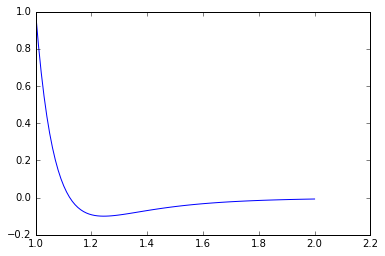

In [165]:
ddr = np.linspace(1,2,100)
Fplot = (2/(ddr**13) - (1/(ddr**7)))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(ddr,Fplot)